In [2]:
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)

import numpy as np
import h5py as h5
from scipy import optimize as opt
from scipy.signal import savgol_filter
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from os import path

from importlib import reload
from cassie import *

%matplotlib inline


def fringe(nu, nu_0, ramsey_period, amp, offset):
    return amp*np.cos(np.pi*(nu-nu_0)/(ramsey_period))**2. + offset


def rabi(t, nu, delta, gamma):
    s = np.sin(np.pi*np.sqrt(nu*nu + 4*delta*delta)*t)
    a = nu*nu/(nu*nu + 4*delta*delta)
    d = np.exp(-np.abs(gamma)*t)
    return a*(s*s*d + 0.5*(1-d))*(t>0)

p:	 0.12387490837039368 	+/-	 0.07472962085337242
q:	 0.7374962138953571 	+/-	 0.0785040529138262
m0:	 795.4479211381537 	+/-	 5.159406249102888
m1:	 740.733211044524 	+/-	 1.3284103949212347
s0:	 16.50433632952045 	+/-	 4.296525685965606
s1:	 23.336054007943044 	+/-	 1.7022969363063987
Based on 11521 data points 

Saved file: 20201221_025.txt 



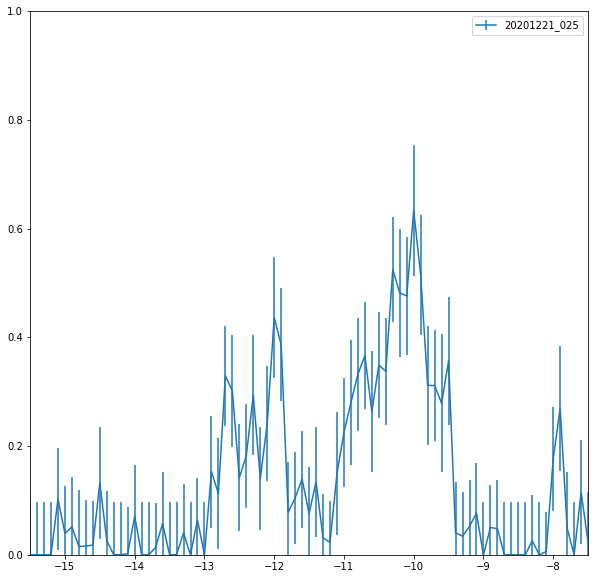

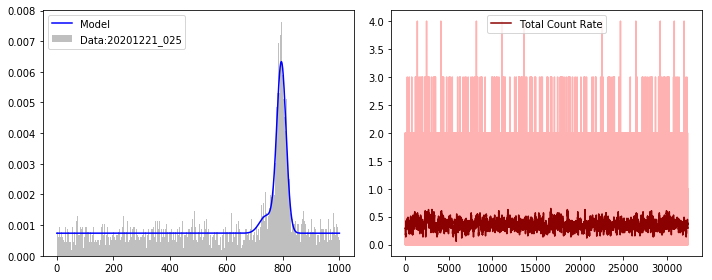

In [13]:
year = "2020"
month = "12"
day = "21"
ymd = year+month+day
nums = ["025"]
xunit = 1e6


mle = MaximumLikelihoodEstimator(default_model)

bigfig, bigax = plt.subplots(figsize = (10, 10))

biggest_x = -np.inf
smallest_x = np.inf

for n in nums:
    fname = "Q:\\E11_hybrid\\scan_data\\"+year+"\\"+month+"\\"+day+"\\"+ymd+"_"+n+"\\"+ymd+"_"+n+"_scan.h5"
    data = h5.File(fname, 'r', swmr = True)
    scope = data['osc_0'].value
    indy_var = np.array([d[0] for d in data['analysis']])
    data.close()
    trace_dist = np.zeros(len(scope[0]))
    timebins = np.arange(len(scope[0]))
    digitised = {v:[] for v in indy_var}
    all_hits = []
    
    counttracker = np.zeros(len(scope))
    
    for k, trace in enumerate(scope):
        edges = locate_edges(trace).tolist()
        digitised[indy_var[k]] += edges
        all_hits += edges
        counttracker[k] = len(edges)
        trace_dist[edges] += 1

    mle.set_data(np.array(all_hits).reshape(1, -1))

    popt, pcov = mle.estimate(
        p = 0.5,
        q = 0.5,
        m0 = 795,
        m1 = 739,
        s0 = 10.,
        s1 = 20.
    )
    
    newfixes = {'q':popt[1],'m0':popt[2], 'm1':popt[3], 's0':popt[4], 's1':popt[5]}
    pnames = default_model.get_param_names()
    for k, val in enumerate(popt):
        print(pnames[k+1]+":\t",val,"\t+/-\t",np.sqrt(pcov[k, k]))
    print("Based on",np.size(all_hits),"data points \n")

    default_model.fix_params(**newfixes)
    
    x = np.sort([v for v in digitised])
    p = np.zeros_like(x)
    sigma = np.zeros_like(x)
    
    for idx, point in enumerate(x):
        mle.set_data(np.array(digitised[point]))
        xpopt, xpcov = mle.estimate(p=0)
        p[idx] = xpopt[0]
        sigma[idx] = np.sqrt(xpcov[0,0])
    
    for k in range(10):
        for idx, point in enumerate(x):
            if idx in locate_outliers(sigma)[0]:
                mle.set_data(np.array(digitised[point]))
                xpopt, xpcov = mle.estimate(p=np.random.uniform())
                p[idx] = xpopt[0]
                sigma[idx] = np.sqrt(xpcov[0,0])
                
    
    for idx, point in enumerate(x):
            if idx in locate_outliers(sigma)[0]:
                if p[idx] == 1 or p[idx] == 0:
                    sigma[idx] = np.mean([sigma[j] for j in range(len(sigma)) if j not in locate_outliers(sigma)[0]])
    
    default_model.fix_params(**{k:None for k in pnames})
    
    model_args = [default_model.get_param_defaults()[p] for p in pnames]
    model_args[0] = timebins
    for k, val in enumerate(popt):
        model_args[k+1] = val

    subfig, subax = plt.subplots(1, 2, figsize = (10, 4))
    subax[0].bar(timebins, trace_dist/np.sum(trace_dist), width = 1, alpha = 0.5, color = 'grey', label = "Data:"+ymd+"_"+n)
    subax[0].plot(timebins, default_model(*model_args), color = 'blue', label = "Model")
    subax[0].legend()
    subax[1].plot(counttracker,alpha=0.3,color='red')
    subax[1].plot(savgol_filter(counttracker,51,0),color='darkred',label="Total Count Rate")
    subax[1].legend()
    subfig.tight_layout()
    
    bigax.errorbar(x*xunit, p, yerr = sigma, label = ymd+"_"+n)
    
    np.savetxt(ymd+"_"+n+".txt", np.vstack((x, p, sigma)))
    print("Saved file:",ymd+"_"+n+".txt","\n")
    
    biggest_x = np.maximum(biggest_x, x[-1])
    smallest_x = np.minimum(smallest_x, x[0])

bigax.set_ylim([0, 1])
bigax.set_xlim([xunit*smallest_x, xunit*biggest_x])
bigax.legend()
plt.show()

p:	 0.07932281011864113 	+/-	 0.21041472812424608
q:	 0.6874519428009342 	+/-	 0.06777743019786407
m0:	 797.6835425884425 	+/-	 22.04294344994046
m1:	 739.7375356915144 	+/-	 10.77623044278544
s0:	 16.960804749709446 	+/-	 1.5653104013799461
s1:	 9.561405336890278 	+/-	 9.451976049688133
Based on 19935 data points 

Saved file: 20201124_009.txt 



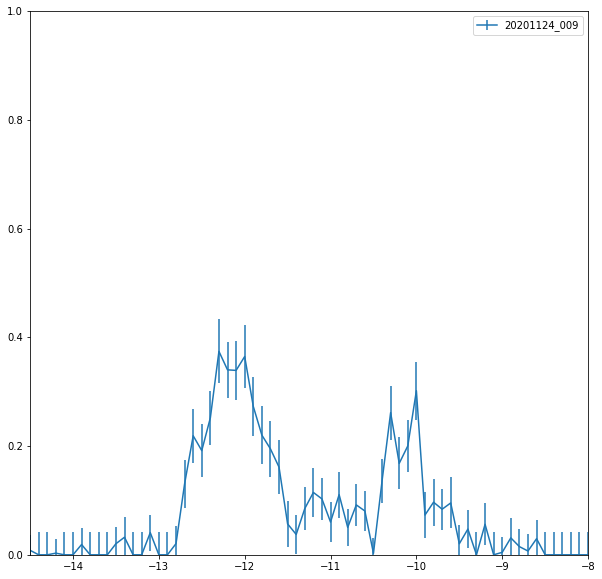

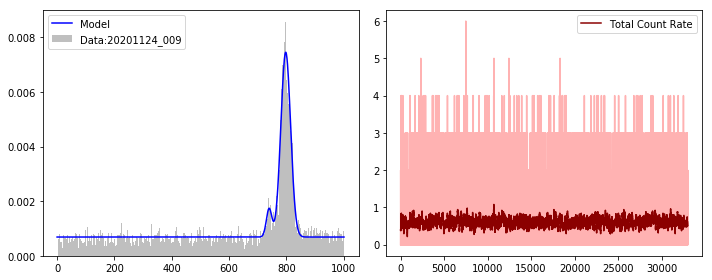

In [14]:
year = "2020"
month = "11"
day = "24"
ymd = year+month+day
#nums=["000","001","002"]
nums = ["009"]
xunit = 1e6


mle = MaximumLikelihoodEstimator(default_model)

bigfig, bigax = plt.subplots(figsize = (10, 10))

biggest_x = -np.inf
smallest_x = np.inf

for n in nums:
    fname = "Q:\\E11_hybrid\\scan_data\\"+year+"\\"+month+"\\"+day+"\\"+ymd+"_"+n+"\\"+ymd+"_"+n+"_scan.h5"
    data = h5.File(fname, 'r', swmr = True)
    scope = data['osc_0'].value
    indy_var = np.array([d[0] for d in data['analysis']])
    data.close()
    trace_dist = np.zeros(len(scope[0]))
    timebins = np.arange(len(scope[0]))
    digitised = {v:[] for v in indy_var}
    all_hits = []
    
    counttracker = np.zeros(len(scope))
    
    for k, trace in enumerate(scope):
        edges = locate_edges(trace).tolist()
        digitised[indy_var[k]] += edges
        all_hits += edges
        counttracker[k] = len(edges)
        trace_dist[edges] += 1

    mle.set_data(np.array(all_hits).reshape(1, -1))

    popt, pcov = mle.estimate(
        p = 0.5,
        q = 0.5,
        m0 = 795,
        m1 = 739,
        s0 = 10.,
        s1 = 20.
    )
    
    newfixes = {'q':popt[1],'m0':popt[2], 'm1':popt[3], 's0':popt[4], 's1':popt[5]}
    pnames = default_model.get_param_names()
    for k, val in enumerate(popt):
        print(pnames[k+1]+":\t",val,"\t+/-\t",np.sqrt(pcov[k, k]))
    print("Based on",np.size(all_hits),"data points \n")

    default_model.fix_params(**newfixes)
    
    x = np.sort([v for v in digitised])
    p = np.zeros_like(x)
    sigma = np.zeros_like(x)
    
    for idx, point in enumerate(x):
        mle.set_data(np.array(digitised[point]))
        xpopt, xpcov = mle.estimate(p=0)
        p[idx] = xpopt[0]
        sigma[idx] = np.sqrt(xpcov[0,0])
    
    for k in range(10):
        for idx, point in enumerate(x):
            if idx in locate_outliers(sigma)[0]:
                mle.set_data(np.array(digitised[point]))
                xpopt, xpcov = mle.estimate(p=np.random.uniform())
                p[idx] = xpopt[0]
                sigma[idx] = np.sqrt(xpcov[0,0])
                
    
    for idx, point in enumerate(x):
            if idx in locate_outliers(sigma)[0]:
                if p[idx] == 1 or p[idx] == 0:
                    sigma[idx] = np.mean([sigma[j] for j in range(len(sigma)) if j not in locate_outliers(sigma)[0]])
    
    default_model.fix_params(**{k:None for k in pnames})
    
    model_args = [default_model.get_param_defaults()[p] for p in pnames]
    model_args[0] = timebins
    for k, val in enumerate(popt):
        model_args[k+1] = val

    subfig, subax = plt.subplots(1, 2, figsize = (10, 4))
    subax[0].bar(timebins, trace_dist/np.sum(trace_dist), width = 1, alpha = 0.5, color = 'grey', label = "Data:"+ymd+"_"+n)
    subax[0].plot(timebins, default_model(*model_args), color = 'blue', label = "Model")
    subax[0].legend()
    subax[1].plot(counttracker,alpha=0.3,color='red')
    subax[1].plot(savgol_filter(counttracker,51,0),color='darkred',label="Total Count Rate")
    subax[1].legend()
    subfig.tight_layout()
    
    bigax.errorbar(x*xunit, p, yerr = sigma, label = ymd+"_"+n)
    
    np.savetxt(ymd+"_"+n+".txt", np.vstack((x, p, sigma)))
    print("Saved file:",ymd+"_"+n+".txt","\n")
    
    biggest_x = np.maximum(biggest_x, x[-1])
    smallest_x = np.minimum(smallest_x, x[0])

bigax.set_ylim([0, 1])
bigax.set_xlim([xunit*smallest_x, xunit*biggest_x])
bigax.legend()
plt.show()

p:	 0.34303532017388727 	+/-	 0.4973867192767006
q:	 0.6334722904642341 	+/-	 0.10131695866384074
m0:	 794.644885572833 	+/-	 29.42584377350103
m1:	 743.718125026132 	+/-	 8.803190419681716
s0:	 20.027582148862884 	+/-	 17.180669404772065
s1:	 13.692872514494612 	+/-	 12.649208655716382
Based on 3550 data points 

020: [0.00232151 0.00061469 0.00091481]
[[ 7.90510838e-09 -2.39977458e-09  5.39540699e-09]
 [-2.39977458e-09  2.61332041e-09 -2.98796611e-09]
 [ 5.39540699e-09 -2.98796611e-09  1.01207296e-07]]
Saved file: 20201221_020.txt 

p:	 0.34057586453918126 	+/-	 1.043052192315129
q:	 0.6106876354639369 	+/-	 0.5311500214657886
m0:	 792.7146780803773 	+/-	 2.325624374025928
m1:	 740.1450994282419 	+/-	 3.8616548338751846
s0:	 22.205406013563906 	+/-	 47.0281926140333
s1:	 12.55582457644859 	+/-	 1.8609394079582071
Based on 3505 data points 

021: [0.00260509 0.00070345 0.00203993]
[[ 9.02137989e-09 -1.90832291e-09  1.65591930e-09]
 [-1.90832291e-09  3.45574880e-09 -5.35143525e-09]
 [ 

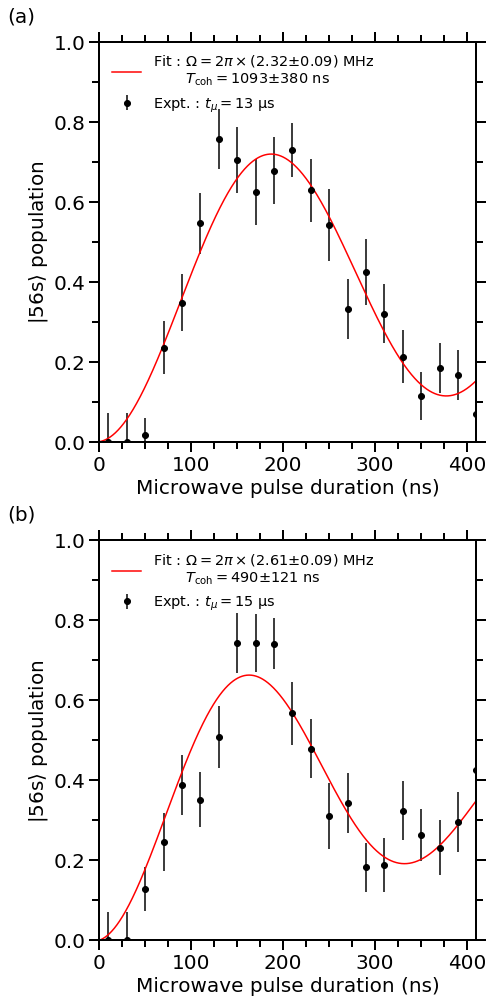

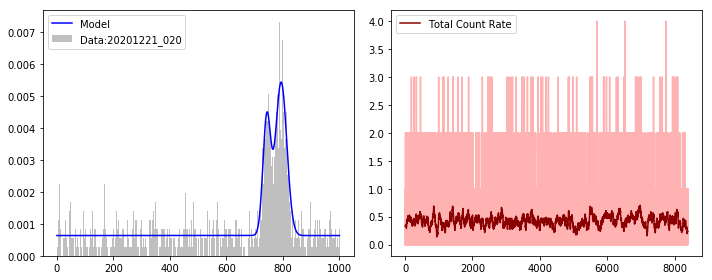

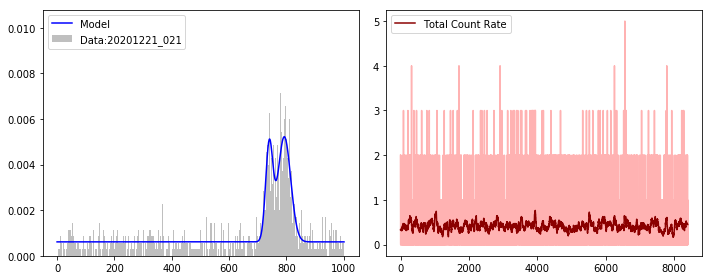

In [16]:
year = "2020"
month = "12"
day = "21"
ymd = year+month+day
nums = ["020","021"]

xunit = 1e9


mle = MaximumLikelihoodEstimator(default_model)

labels = (r"Expt. : $t_{\mu} = 13\;\mathrm{\mu s}$",r"Expt. : $t_{\mu} = 15\;\mathrm{\mu s}$")
bigfig, bigax = plt.subplots(2, 1, figsize = (7, 14))

biggest_x = -np.inf
smallest_x = np.inf

guesses = (
    [2.1e-3, 0, 1/300],
    [2.94e-3, 0, 1/300]
)

for i, n in enumerate(nums):
    fname = "Q:\\E11_hybrid\\scan_data\\"+year+"\\"+month+"\\"+day+"\\"+ymd+"_"+n+"\\"+ymd+"_"+n+"_scan.h5"
    data = h5.File(fname, 'r', swmr = True)
    scope = data['osc_0'].value
    indy_var = np.array([d[0] for d in data['analysis']])
    data.close()
    trace_dist = np.zeros(len(scope[0]))
    timebins = np.arange(len(scope[0]))
    digitised = {v:[] for v in indy_var}
    all_hits = []
    
    counttracker = np.zeros(len(scope))
    
    for k, trace in enumerate(scope):
        edges = locate_edges(trace).tolist()
        digitised[indy_var[k]] += edges
        all_hits += edges
        counttracker[k] = len(edges)
        trace_dist[edges] += 1

    mle.set_data(np.array(all_hits).reshape(1, -1))

    popt, pcov = mle.estimate(
        p = 0.5,
        q = 0.5,
        m0 = 795,
        m1 = 739,
        s0 = 10.,
        s1 = 20.
    )
    
    newfixes = {'q':popt[1],'m0':popt[2], 'm1':popt[3], 's0':popt[4], 's1':popt[5]}
    pnames = default_model.get_param_names()
    for k, val in enumerate(popt):
        print(pnames[k+1]+":\t",val,"\t+/-\t",np.sqrt(pcov[k, k]))
    print("Based on",np.size(all_hits),"data points \n")

    default_model.fix_params(**newfixes)
    
    x = np.sort([v for v in digitised])
    p = np.zeros_like(x)
    sigma = np.zeros_like(x)
    
    for idx, point in enumerate(x):
        mle.set_data(np.array(digitised[point]))
        xpopt, xpcov = mle.estimate(p=0)
        p[idx] = xpopt[0]
        sigma[idx] = np.sqrt(xpcov[0,0])
    
    for k in range(10):
        for idx, point in enumerate(x):
            if idx in locate_outliers(sigma)[0]:
                mle.set_data(np.array(digitised[point]))
                xpopt, xpcov = mle.estimate(p=np.random.uniform())
                p[idx] = xpopt[0]
                sigma[idx] = np.sqrt(xpcov[0,0])
                
    
    for idx, point in enumerate(x):
            if idx in locate_outliers(sigma)[0]:
                if p[idx] == 1 or p[idx] == 0:
                    sigma[idx] = np.mean([sigma[j] for j in range(len(sigma)) if j not in locate_outliers(sigma)[0]])
    
    default_model.fix_params(**{k:None for k in pnames})
    
    model_args = [default_model.get_param_defaults()[p] for p in pnames]
    model_args[0] = timebins
    for k, val in enumerate(popt):
        model_args[k+1] = val

    subfig, subax = plt.subplots(1, 2, figsize = (10, 4))
    subax[0].bar(timebins, trace_dist/np.sum(trace_dist), width = 1, alpha = 0.5, color = 'grey', label = "Data:"+ymd+"_"+n)
    subax[0].plot(timebins, default_model(*model_args), color = 'blue', label = "Model")
    subax[0].legend()
    subax[1].plot(counttracker,alpha=0.3,color='red')
    subax[1].plot(savgol_filter(counttracker,51,0),color='darkred',label="Total Count Rate")
    subax[1].legend()
    subfig.tight_layout()
    
    bigax[i].errorbar(x*xunit, p, yerr = sigma, label = labels[i],color='k',
                   linestyle="None", marker='o')
    
    popt, pcov = opt.curve_fit(rabi, x*xunit,  p,
                               sigma = sigma,
                               p0 = guesses[i],
                               maxfev=10000)
    calc_x = np.linspace(0, max(x*xunit), 1000)
    bigax[i].plot(calc_x, rabi(calc_x, *popt), 
               label=
               "Fit : " + 
               r"$\Omega = 2 \pi \times (${0:4.2f}$\pm${1:4.2f}$)$ MHz".format(popt[0]*1e3, np.sqrt(pcov[0,0])*1e3) +
               "\n       " +
               r"$T_{\mathrm{coh}}$"+r"$ = ${0:.0f}$\pm${1:.0f} ns".format(1./popt[2], np.sqrt(pcov[2,2])/(popt[2]*popt[2])),
               color='r')
    print(n+":",popt)
    print(pcov)
    
    bigax[i].set_ylim([0, 1])
    bigax[i].set_xlim([0, max(calc_x)])
    bigax[i].text(-100, 1.05, ["(a)","(b)"][i], fontsize=20)
    bigax[i].legend(fontsize = 14.5, loc = "upper left", framealpha = 0.)
    bigax[i].set_xlabel("Microwave pulse duration (ns)",fontsize=20)
    bigax[i].set_ylabel(r"$|56\mathrm{s}\rangle$ population",fontsize=20)
    
    bigax[i].tick_params(width=2,labelsize=20,length=10, top=True, right=True)
    bigax[i].tick_params(which="minor", width=2, length=7, top=True, right=True)
    bigax[i].xaxis.set_minor_locator(MultipleLocator(25))
    bigax[i].yaxis.set_minor_locator(MultipleLocator(0.1))
    for loc in ("top","bottom","left","right"):
        bigax[i].spines[loc].set_linewidth(2)
    
    np.savetxt(ymd+"_"+n+".txt", np.vstack((x, p, sigma)))
    print("Saved file:",ymd+"_"+n+".txt","\n")
    
    biggest_x = np.maximum(biggest_x, x[-1])
    smallest_x = np.minimum(smallest_x, x[0])

bigfig.tight_layout()
bigfig.savefig("two_loc_Rabi_reprocessed.pdf", dpi = 1000, bbox_inches = "tight")
plt.show()

In [ ]:

labels = (r"Expt. : $t_{\mu} = 13\;\mathrm{\mu s}$",r"Expt. : $t_{\mu} = 15\;\mathrm{\mu s}$")
bigfig, bigax = plt.subplots(2, 1, figsize = (7, 14))

for i, n in enumerate(nums):
    
    fname = "Q:\\E11_hybrid\\scan_data\\"+year+"\\"+month+"\\"+day+"\\"+ymd+"_"+n+"\\"+ymd+"_"+n+"_scan.h5"
    data = h5.File(fname, 'r', swmr = True)
    scope = data['osc_0'].value
    indy_var = np.array([d[0] for d in data['analysis']])
    data.close()
    digitised = {v:np.zeros(len(scope[0])) for v in indy_var}
    trace_basis = np.arange(len(scope[0]))
    
    windows = [
        np.exp(-0.5*((trace_basis - 803 + 5)/15.)**2.), 
        np.exp(-0.5*((trace_basis - 745 + 3)/15.)**2.)
    ]
    
    ovl = np.min(windows, axis=0)
    
    postselector = np.sum(windows, axis=0)>0.1
    max_atoms=8
    postselected = {v:np.zeros((max_atoms+1, len(scope[0]))) for v in indy_var}
    
    counttracker = np.zeros(len(scope))
    signaltracker = np.zeros(len(scope))
    
    for k, trace in enumerate(scope):
        edges = locate_edges(trace, volt_threshold, grad_threshold)
        this_trace = np.zeros(len(scope[0]))
        this_trace[edges] += 1
        digitised[indy_var[k]] += this_trace
        atoms_in_trace = int(np.sum(this_trace*postselector))
        postselected[indy_var[k]][atoms_in_trace] += this_trace
        counttracker[k] = np.sum(this_trace)
        signaltracker[k] = np.sum(this_trace*postselector)
    
    
    x = np.sort([v for v in digitised])
    trace_dist = np.sum(np.array([digitised[v] for v in x]), axis = 0)
    y = np.array([[np.sum((w-ovl)*(digitised[v] - np.mean(digitised[v][:600]))) for w in windows] for v in x])
    
    bkg_sig = np.array([np.std(digitised[v][:600]) for v in x])
    W = np.sqrt(np.sum((windows[1]-ovl)**2.))
    
    y_post = np.array(
        [[np.sum((w-ovl)*(postselected[v] - np.mean(postselected[v][:,:600],axis=1).reshape(max_atoms+1,1))
                 ,axis=1) for w in windows] for v in x]
    )
    
    bkg_sig_post = np.array(
        [np.std(postselected[v][:,:600],axis=1) for v in x]
    )
    

    p = y[:,1]/(y[:,0]+y[:,1])
    corr = np.corrcoef(y.T)[0, 1]
    dp = bkg_sig*W*np.sqrt(p**2 + (1-p)**2 - 2*p*(1-p)*corr)/np.abs(y[:,0]+y[:,1])
    norm_post = (y_post[:,0,:] + y_post[:,1,:])
    p_post = y_post[:,1,:]/norm_post
    corr_post = np.array([np.corrcoef(y_post[:,:,a].T)[0,1] for a in range(max_atoms+1)])
    dp_post = bkg_sig_post*W*np.sqrt((1-p_post)**2 + p_post**2 - 2*p_post*(1-p_post)*corr_post)/np.abs(norm_post)
    dp_post[dp_post==0] += np.min(dp_post[dp_post>0])
    
    bigax[i].errorbar(x*xunit, p_post[:,1], yerr = dp_post[:,1], label = labels[i],color='k',
                   linestyle="None", marker='o')
    popt, pcov = opt.curve_fit(rabi, x*xunit,  p_post[:,1],
                               sigma = dp_post[:,1],
                               p0 = guesses[i],
                               maxfev=10000)
    calc_x = np.linspace(0, max(x*xunit), 1000)
    bigax[i].plot(calc_x, rabi(calc_x, *popt), 
               label=
               "Fit : " + 
               r"$\Omega = 2 \pi \times (${0:4.2f}$\pm${1:4.2f}$)$ MHz".format(popt[0]*1e3, np.sqrt(pcov[0,0])*1e3) +
               "\n       " +
               r"$T_{\mathrm{coh}}$"+r"$ = ${0:.0f}$\pm${1:.0f} ns".format(1./popt[2], np.sqrt(pcov[2,2])/(popt[2]*popt[2])),
               color='r')
    print(n+":",popt)
    print(pcov)
    
    bigax[i].set_ylim([0, 1])
    bigax[i].set_xlim([0, max(calc_x)])
    bigax[i].text(-100, 1.05, ["(a)","(b)"][i], fontsize=20)
    bigax[i].legend(fontsize = 14.5, loc = "lower center")
    bigax[i].set_xlabel("Microwave pulse duration (ns)",fontsize=20)
    bigax[i].set_ylabel(r"$|56\mathrm{s}\rangle$ population",fontsize=20)
    
    bigax[i].tick_params(width=2,labelsize=20,length=10, top=True, right=True)
    bigax[i].tick_params(which="minor", width=2, length=7, top=True, right=True)
    bigax[i].xaxis.set_minor_locator(MultipleLocator(25))
    bigax[i].yaxis.set_minor_locator(MultipleLocator(0.1))
    for loc in ("top","bottom","left","right"):
        bigax[i].spines[loc].set_linewidth(2)
        
plt.savefig("Rabi_EarlyLate_VERT.pdf",dpi=1000, bbox_inches='tight')
plt.show()